# **NBA player salary predictor**

This notebook uses the kaggle dataset [NBA player stats](https://www.kaggle.com/acasalan/nba-player-stats-201718) which contains player stats and salaries for the 2017-2018 season. Using this data, we build several regression models to predict a players salary based on their in-game statistics. The methods used here are intended to provide a walkthrough on model selection, validation and hyperparamenter tuning so we won't focus much on preprocessing.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings(action='ignore')
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('nbaplayers1718.csv')
df.head()

In [3]:
# drop all players who've player less than a quarter (12 minutes)
df = df.loc[df.MP >= 984]

# drop raw count variables
df.drop(['#', 'Player Name', 'Season Start', 'blanl', 'OWS', 'DWS', 'WS', 'WS/48', 'blank2',
         'Tm', 'Pos', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', '3PAr', '3P', '3PA', '2P',
         '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',],
        axis=1, inplace=True)

# remove whitespace
df.columns = df.columns.str.strip()

# remove null values
df.dropna(inplace=True)

# remove symbols from player salary
df['Player Salary in $'] = df['Player Salary in $'].str.replace('$', '')
df['Player Salary in $'] = df['Player Salary in $'].str.replace(',', '')

# convert to numerical value
df['Player Salary in $'] = df['Player Salary in $'].astype('float64')

# create rate features for PF(personal fouls) & PTS(points) based on minutes played
rate_features = ['PF', 'PTS']

for feature_name in rate_features:
    df[feature_name] = df[feature_name]/48
    
# rename PF and PTS columns
df.rename(columns={'PF': 'PF/G',
                   'PTS':'PTS/G'}, inplace=True)

In [4]:
# create train/test sets
from sklearn.model_selection import train_test_split

X = df.drop('Player Salary in $', axis=1)
y = df['Player Salary in $']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Train with GradientBoostingRegressor

Evaluate a gradient boosting regressor model:

In [5]:
# import model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# fit basic model
gb = GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split=2,
                               learning_rate=0.01, loss='ls')
gb.fit(X_train, y_train)

# calculate mean absolute error
mae = mean_absolute_error(y_train, gb.predict(X_train))
maPe = mae*100.0/y_train.mean()
print(f'${mae:.0f} average error; {maPe:.2f}% error')

$958956 average error; 9.14% error


There are many scoring metrics we can use, but in this case, we will choose the mean absolute error. The mean absolute error represents the average difference between the actual value and the predicted value. In other words, we can expect the predicted player salary to be off by $958K or ~9%. This is not bad for a basic model, but we can do better by optimizing the hyperparameters. The hyperparameters refer to features that aren't learnt from the model and have a profound effect in dictating the architecture of the model. By fiddling with these hyperparameters, we can often expect a boost in model performance.

Two methods for obtaining the best combination of hyperparameters are `GridSearchCV` and `RandomizedSearchCV`. Both functions are similar in that they search through a grid of specified parameter values, but differ in their search strategy. `GridSearchCV` **exhaustively** searches for the best combination while `RandomizedSearchCV` performs a random search and each setting is sampled from a distribution of potential parameter values. In other words, only a **certain number** of parameter settings are sampled and we can control the number of parameter settings to try by specifiying the `n_iter` argument. Increasing `n_iter` leads to a finer search at the cost of increased runtime. In general, `RandomizedSearchCV` is more effective because some hyperparameters matter more than others and performing a random search allows you to more precisely discover good values for these important hyperparameters. Check out this [article](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) for a more in-depth explanation.

In cases where the dataset is smaller, it may be better to employ a cross-validation strategy to evaluate model performance. We can do this directly by specifying the `cv` argument in the randomized search. Here, we perform a 5-fold cross validation. This means we split the training data into 5 equal folds, train on 4 of them and use 1 for validation. Then we iterate through each fold as the validation fold and average the performance across all folds. While this is considered a more robust validation strategy, people prefer to avoid it because it can be computationally expensive if you have a large dataset.

In [6]:
# import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# create grid of hyperparameters to search
params = {'loss':['ls', 'lad', 'huber'],
          'learning_rate':[0.1, 0.001],
          'n_estimators':[100, 500, 1000],
          'min_samples_split':[2, 4, 6],
          'min_samples_leaf':[2, 4, 6],
          'max_depth':[5, 10, 20],
          'max_features':['auto', 'log2', 'sqrt']}

model = GradientBoostingRegressor()

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=params,
                               cv=5, n_iter=25, n_jobs=-1,
                               scoring='neg_mean_absolute_error')

random_cv.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'learning_rate': [0.1, 0.001], 'n_estimators': [100, 500, 1000], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [2, 4, 6], 'max_depth': [5, 10, 20], 'max_features': ['auto', 'log2', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [7]:
# get best parameters
random_cv.best_params_

{'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'loss': 'lad',
 'learning_rate': 0.1}

In [8]:
# input new hyperparameters to model
gb = GradientBoostingRegressor(n_estimators=100, max_depth=10, min_samples_split=4,
                               learning_rate=0.1, loss='lad', min_samples_leaf=4,
                               max_features='sqrt')
gb.fit(X_train, y_train)

# calculate mean absolute error
mae = mean_absolute_error(y_train, gb.predict(X_train))
maPe = mae*100.0/y_train.mean()
print(f'${mae:.0f} average error; {maPe:.2f}% error')

$58837 average error; 0.56% error


Post-tuning, we reduced the average error to $58K and are off by less than 1%, which translates to a ~16% increase in prediction accuracy.

In [9]:
# fit model to test data
gb.fit(X_test, y_test)

# calculate mean absolute error
mae = mean_absolute_error(y_test, gb.predict(X_test))
maPe = mae*100.0/y_test.mean()
print(f'${mae:.0f} average error; {maPe:.2f}% error')

$34304 average error; 0.39% error


Finally, after fitting the model to the training set, we get an average error of $34K and ~0.4% error.

At this point, we are confident in the model's ability to generalize to previously unseen data because the training and test MAE track pretty closely together. If say the test MAE was significantly greater than the training MAE, then that would indicate the model has overfit the data.

# Explain the GradientBoostingRegressor

We can use [SHAP](https://github.com/slundberg/shap) to explain the model output.

In [10]:
# import SHAP and load JS visualization code to notebook
import shap
shap.initjs()

# explain the model's predictions using the TreeExplainer
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X_test)

## Explain a single player's salary

In [18]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

The red values show features that push the prediction (player salary) higher while blue values represents features that lowers the model output from the expected base value (average model output). For this particular player: age, points/game and usage percentage are the largest factors contributing to a lower salary while their most redeeming quality appears to be defensive rebounding. 

## Explain many player's salary

We can also visualize the explanations across the entire dataset (plot is interactive).

In [13]:
# visualize the test set predictions
shap.force_plot(explainer.expected_value, shap_values, X_test)

## Summarize impact of all features

Finally, to get a summary of the most important features we can plot the SHAP values of every feature. In doing so, we can easily visualize which features drives the model prediction from the most to the least. Each dot is colored according to the value of that feature for a specific prediction. For this model, age and points/game affect a player's salary the most while free throw percentage and games played affect the model prediction the least.

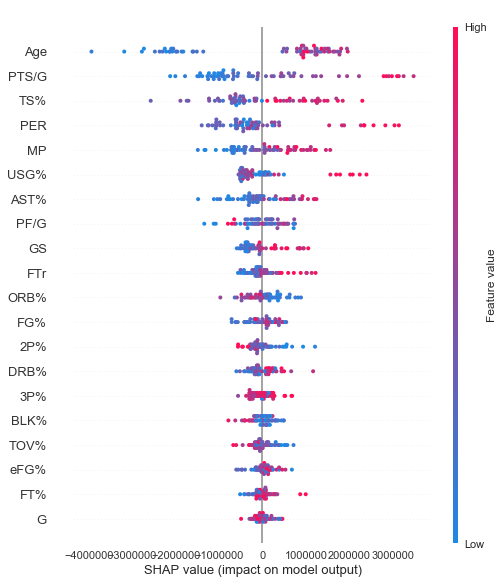

In [16]:
sns.set_style('white')

# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)